In [3]:
import os

import statistics 
import numpy as np
import pandas as pd

from scipy import ndimage

import matplotlib.pyplot as plt

from skimage.filters import  threshold_otsu
from skimage import filters

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images                
import skimage.transform 
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, add
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K

#Model evaluation
from scipy.spatial import distance
from sklearn.metrics import jaccard_score, accuracy_score
%tensorflow_version 1.x
import tensorflow as tf

Using TensorFlow backend.


##Download data

In [4]:
# # Default title text
!pip install -q kaggle
import os
os.environ['KAGGLE_USERNAME'] = "****"
os.environ['KAGGLE_KEY'] = "******"
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 4.81MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.8MB/s]
 88% 8.00M/9.10M [00:00<00:00, 82.8MB/s]
100% 9.10M/9.10M [00:00<00:00, 83.6MB/s]
 92% 73.0M/79.1M [00:02<00:00, 20.7MB/s]
100% 79.1M/79.1M [00:02<00:00, 32.9MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 99.3MB/s]
 97% 269M/276M [00:02<00:00, 133MB/s]
100% 276M/276M [00:02<00:00, 128MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 122MB/s]


In [6]:
# View files
!ls

sample_data			  stage1_train
stage1_sample_submission.csv.zip  stage1_train_labels.csv.zip
stage1_solution.csv.zip		  stage1_train.zip
stage1_test			  stage2_sample_submission_final.csv.zip
stage1_test.zip			  stage2_test_final.zip


##Pre-processing

Get parameters

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train'
TEST_PATH = 'stage1_test'

Get and resize train images and masks

In [0]:
def get_train_data(path_file, train=True):
  # Get train and test IDs
  ids = next(os.walk(path_file))[1]

  X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
  if train:
    y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
      path = path_file + "/" + id_
      # import images
      img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X[n] = img /255

      # import masks
      if train:
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        y[n] = mask

  return X,y


In [9]:
X_train,y_train = get_train_data(TRAIN_PATH)

100%|██████████| 670/670 [06:09<00:00,  3.43it/s]


In [10]:
def get_test_data(path_file, train=True):
  # Get train and test IDs
  ids = next(os.walk(path_file))[1]

  X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
      path = path_file + "/" + id_
      # import images
      img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X[n] = img /255
  return X

X_test = get_test_data(TEST_PATH, train=False)
print(X_test.shape, X_test.dtype)

100%|██████████| 65/65 [00:02<00:00, 31.66it/s]

(65, 256, 256, 3) float32


In [11]:
#check shape,  type
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

(670, 256, 256, 3) float32
(670, 256, 256, 1) bool


In [0]:
#split train and valid set
X_train_edit, X_valid_edit, y_train_edit, y_valid_edit = train_test_split(X_train, y_train, test_size = 0.2, random_state= 1)

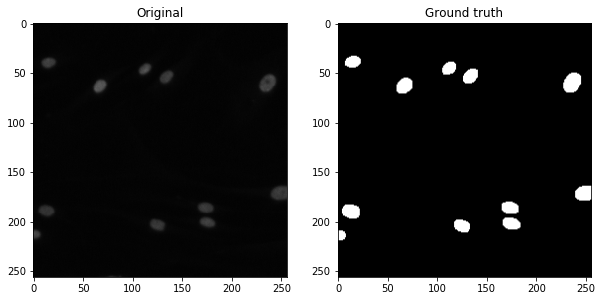

In [13]:
# Check if training data looks all right
import random
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(X_train[ix])
# if has_mask:
#     ax[0].contour(y_train[ix].squeeze(), colors='r', levels=[0.5])
ax[0].set_title('Original')
ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Ground truth');

In [14]:
X_train_edit.shape

(536, 256, 256, 3)

## Baseline segmentation

####Ostu thresholding

In [0]:
# otsu threshold
def otsu_threshold(image_set):
  nr_im, height, width, _= image_set.shape
  results = np.zeros((nr_im, height, width, 1))
  for i in range(image_set.shape[0]):
    im = image_set[i][:,:,1]
    binary = im > threshold_otsu(im)
    binary = binary.reshape((height, width, 1))
    results[i] = binary
  return results

ostu_train = otsu_threshold(X_train_edit)
ostu_valid = otsu_threshold(X_valid_edit)
# plt.figure(figsize= (5,5))
# plt.imshow(binary,cmap= 'gray')

(-0.5, 255.5, 255.5, -0.5)

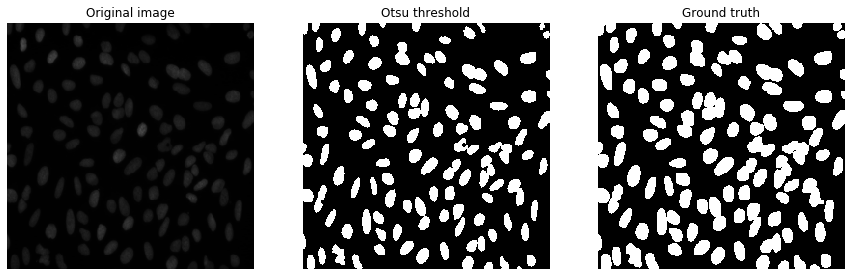

In [16]:
original = X_train_edit[6]
im = ostu_train[6][:,:,0]
mask = y_train_edit[6][:,:,0]

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(original)
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].set_title('Otsu threshold')
ax[1].axis('off')
ax[2].imshow(mask, cmap=plt.cm.gray)
ax[2].set_title('Ground truth')
ax[2].axis('off')

In [0]:
#Create function to evaluate models
from scipy.spatial import distance
from sklearn.metrics import jaccard_score

def evaluation(truth, prediction):
  jaccard=[]
  hausdorff=[]
  dice_dist= []
  for i in range(prediction.shape[0]):
    img_true= np.array(truth[i][:,:,0]).astype(float)
    img_pred= np.array(prediction[i][:,:,0])
    img_pred= img_pred >  threshold_otsu(img_pred)

    # print(img_true)
    jaccard.append(jaccard_score(img_true, img_pred, average= "micro"))
    hausdorff.append(distance.directed_hausdorff(img_true, img_pred)[0])
    dice_dist.append(1 - distance.dice(img_true.ravel(), img_pred.ravel()))

  jaccard =  statistics.mean(jaccard)
  hausdorff = statistics.mean(hausdorff)
  dice_dist = statistics.mean(dice_dist)

  return (jaccard, hausdorff, dice_dist)

In [18]:
j_1,h_1,d_1 = evaluation(y_valid_edit, ostu_valid)


print("Jaccard similarity: {}".format(j_1))
print("Hausdorff distance: {}".format(h_1))
print("Dice coefficient: {}".format(d_1))

Jaccard similarity: 0.6033136243812206
Hausdorff distance: 6.194351211950366
Dice coefficient: 0.6968230429471817


####Watershed

In [0]:
from skimage.filters import rank 
from skimage.morphology import disk, watershed
from skimage.feature import peak_local_max

def watershed_segment(image_set):
    #detection parameters
  smooth_size = 5 # pixels
  min_radius = 4
  max_radius = 20
 
  nr_im, height, width, _= image_set.shape
  results = np.zeros((nr_im, height, width, 1))

  for i in range(image_set.shape[0]):
    im = image_set[i][:,:,1]
    # denoise image: image smoothing
    im = rank.mean(im, disk(1))
    # otsu thresholding
    binary= im > threshold_otsu(im)
    # watershed
    distance = ndimage.distance_transform_edt(binary)
    local_maxi = peak_local_max(distance, min_distance=2*min_radius,
                            indices=False, labels=binary)
    markers = ndimage.label(local_maxi)[0]
    labeled_stack = watershed(-distance, markers, mask=binary)
    # otsu thresholding
    # binary= labeled_stack > 0.5
    segment = labeled_stack.reshape((height, width, 1))
    results[i] = segment

  return results

In [20]:
watershed_train = watershed_segment(X_train_edit)
watershed_valid = watershed_segment(X_valid_edit)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


float64


(-0.5, 255.5, 255.5, -0.5)

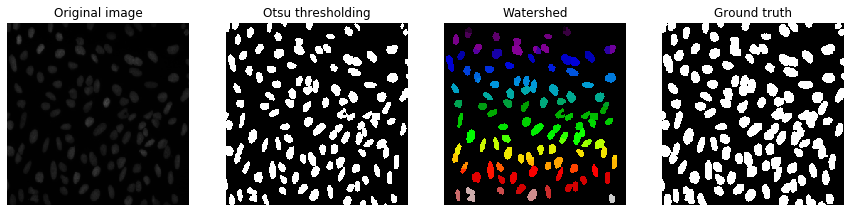

In [21]:
original = X_train_edit[6]
im = watershed_train[6][:,:,0]
ostu = ostu_train[6][:,:,0]
mask = y_train_edit[6][:,:,0]
print(im.dtype)

fig, axes = plt.subplots(ncols=4, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(original)
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(ostu, cmap=plt.cm.gray)
ax[1].set_title('Otsu thresholding')
ax[1].axis('off')
ax[2].imshow(im, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Watershed')
ax[2].axis('off')
ax[3].imshow(mask, cmap=plt.cm.gray)
ax[3].set_title('Ground truth')
ax[3].axis('off')

In [0]:
# j_2,h_2,d_2 = evaluation(y_valid_edit, watershed_valid)

# print("Hausdorff distance: {}".format(j_2))
# print("Jaccard similarity: {}".format(h_2))
# print("Dice coefficient: {}".format(d_2))


## U-net

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [25]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________

In [0]:
seed = 1
batch_size = 16
epochs = 100

####Train model
 

In [27]:
callbacks_1 = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1),
    ModelCheckpoint('u_net', verbose=1, save_best_only=True, save_weights_only=True)]
    
results = model.fit(X_train_edit, y_train_edit, batch_size= batch_size, epochs=epochs, callbacks=callbacks_1,
                    validation_data = (X_valid_edit, y_valid_edit))



Train on 536 samples, validate on 134 samples
Epoch 1/100
536/536 [==============================] - 14s 27ms/step - loss: 0.4251 - acc: 0.8744 - val_loss: 0.4505 - val_acc: 0.9177

Epoch 00001: val_loss improved from inf to 0.45048, saving model to u_net
Epoch 2/100
536/536 [==============================] - 5s 9ms/step - loss: 0.2627 - acc: 0.9441 - val_loss: 0.1873 - val_acc: 0.9516

Epoch 00002: val_loss improved from 0.45048 to 0.18729, saving model to u_net
Epoch 3/100
536/536 [==============================] - 5s 9ms/step - loss: 0.1999 - acc: 0.9593 - val_loss: 0.2054 - val_acc: 0.9513

Epoch 00003: val_loss did not improve from 0.18729
Epoch 4/100
536/536 [==============================] - 5s 9ms/step - loss: 0.1698 - acc: 0.9621 - val_loss: 0.1446 - val_acc: 0.9594

Epoch 00004: val_loss improved from 0.18729 to 0.14455, saving model to u_net
Epoch 5/100
536/536 [==============================] - 5s 9ms/step - loss: 0.1540 - acc: 0.9610 - val_loss: 0.1523 - val_acc: 0.9635


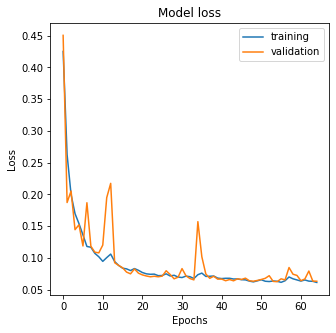

In [28]:
plt.figure(figsize=(5, 5))
plt.title("Model loss")
plt.plot(results.history["loss"], label="training")
plt.plot(results.history["val_loss"], label="validation")
# plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

####Model Evaluation

In [29]:
y_hat_valid_1 = model.predict(X_valid_edit, verbose=1)

134/134 [==============================] - 1s 10ms/step


In [30]:
y_hat_valid_1.shape[:3]

(134, 256, 256)

In [31]:
# model evaluation
j_3,h_3,d_3 = evaluation(y_valid_edit,y_hat_valid_1)

print("Jaccard similarity: {}".format(j_3))
print("Hausdorff distance: {}".format(h_3))
print("Dice coefficient: {}".format(d_3))


Jaccard similarity: 0.8449703827832303
Hausdorff distance: 4.167275718877691
Dice coefficient: 0.9121570857588694


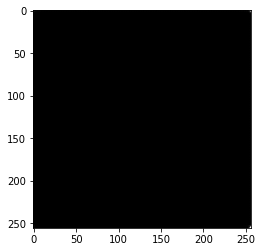

In [32]:
# predict black image
black_image = np.ones((256,256,3))
black_image = black_image.reshape((1,256,256,3))
black_image.shape
black_pred = model.predict(black_image)
black_pred= black_pred.reshape(256,256,1)
plt.imshow(black_pred[:,:,0], cmap="gray")

####Predict model

In [33]:
y_hat_test1 = model.predict(X_test, verbose=1)

65/65 [==============================] - 0s 3ms/step


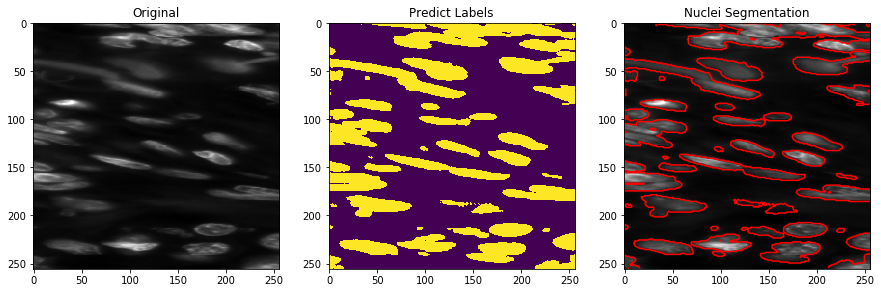

In [34]:
id = random.randint(0, len(X_test))
pred_im = y_hat_test1[id][:,:,0] 
pred_im = pred_im> threshold_otsu(pred_im)
label_im, nb_labels = ndimage.label(pred_im)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(X_test[id])
ax[0].set_title('Original')
ax[1].imshow(pred_im)
ax[1].set_title('Predict Labels');
ax[2].imshow(X_test[id])
ax[2].contour(pred_im, colors='r', levels=[0.5])
ax[2].set_title('Nuclei Segmentation');

##R2U-net

####Build model

In [0]:
def rrcnn_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
  # input
  skip_layer = Conv2D(filters=n_filters, kernel_size=(1,1), kernel_initializer="he_normal",
               padding="same")(input_tensor)
  # 
  layer = skip_layer 
  for j in range(2):
    for i in range(2):
      if i == 0:
        layer1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
        if batchnorm:
          layer1 = BatchNormalization()(layer1)
        layer1 = Activation("relu")(layer1)
      layer1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(add([layer1, layer]))
      if batchnorm:
        layer1 = BatchNormalization()(layer1)
      layer1 = Activation("relu")(layer1)
    layer = layer1

  out_layer = add([layer, skip_layer])
  return out_layer

In [0]:
def r2u_net(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = rrcnn_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = rrcnn_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = rrcnn_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = rrcnn_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = rrcnn_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = rrcnn_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = rrcnn_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = rrcnn_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = rrcnn_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [37]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

model_2 = r2u_net(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model_2.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

### Train model

In [38]:
callbacks_2 = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1),
    ModelCheckpoint('r2u_net', verbose=1, save_best_only=True, save_weights_only=True)]

results_2 = model_2.fit(X_train_edit, y_train_edit, batch_size= batch_size, epochs=epochs, callbacks=callbacks_2,
                    validation_data = (X_valid_edit, y_valid_edit))

Train on 536 samples, validate on 134 samples
Epoch 1/100
536/536 [==============================] - 28s 53ms/step - loss: 0.3604 - acc: 0.8865 - val_loss: 0.2307 - val_acc: 0.9200

Epoch 00001: val_loss improved from inf to 0.23070, saving model to r2u_net
Epoch 2/100
536/536 [==============================] - 12s 23ms/step - loss: 0.1449 - acc: 0.9467 - val_loss: 0.1350 - val_acc: 0.9507

Epoch 00002: val_loss improved from 0.23070 to 0.13505, saving model to r2u_net
Epoch 3/100
536/536 [==============================] - 12s 23ms/step - loss: 0.1154 - acc: 0.9572 - val_loss: 0.1302 - val_acc: 0.9507

Epoch 00003: val_loss improved from 0.13505 to 0.13019, saving model to r2u_net
Epoch 4/100
536/536 [==============================] - 12s 23ms/step - loss: 0.0957 - acc: 0.9633 - val_loss: 0.1552 - val_acc: 0.9486

Epoch 00004: val_loss did not improve from 0.13019
Epoch 5/100
536/536 [==============================] - 12s 23ms/step - loss: 0.0893 - acc: 0.9656 - val_loss: 0.0954 - val_

###Model evaluation

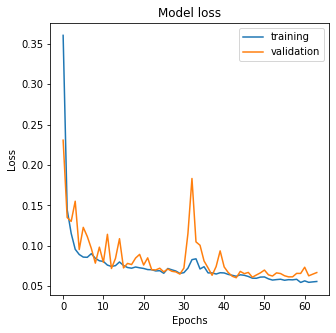

In [39]:
plt.figure(figsize=(5, 5))
plt.title("Model loss")
plt.plot(results_2.history["loss"], label="training")
plt.plot(results_2.history["val_loss"], label="validation")
# plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [40]:
y_hat_valid_2 = model_2.predict(X_valid_edit, verbose=1)
y_hat_valid_2.shape 

134/134 [==============================] - 3s 22ms/step


(134, 256, 256, 1)

In [41]:
# model evaluation
j_4,h_4,d_4 = evaluation(y_valid_edit,y_hat_valid_2)

print("Jaccard similarity: {}".format(j_4))
print("Hausdorff distance:  {}".format(h_4))
print("Dice coefficient: {}".format(d_4))

Jaccard similarity: 0.8436115006085283
Hausdorff distance:  4.279217367497053
Dice coefficient: 0.9110870082733982


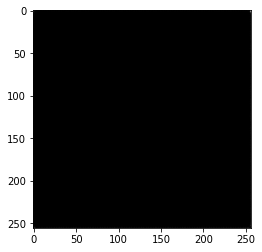

In [42]:
# predict black image
black_image = np.ones((256,256,3))
black_image = black_image.reshape((1,256,256,3))
black_image.shape
black_pred = model_2.predict(black_image)
black_pred= black_pred.reshape(256,256,1)
plt.imshow(black_pred[:,:,0], cmap="gray")

### Predict model

In [43]:
y_hat_test2 = model_2.predict(X_test, verbose=1)

65/65 [==============================] - 0s 7ms/step


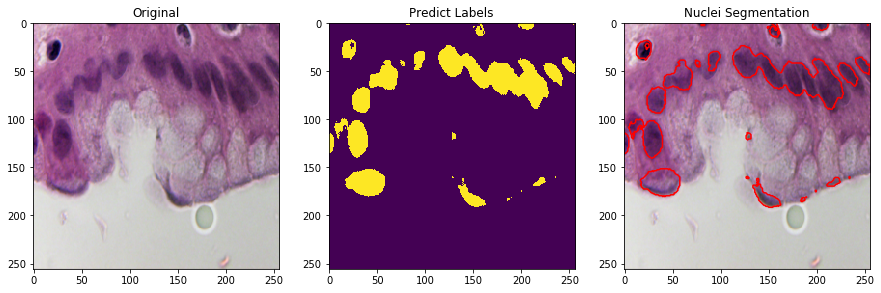

In [44]:
id = random.randint(0, len(X_test))
pred_im = y_hat_test2[id][:,:,0] 
pred_im = pred_im> threshold_otsu(pred_im)
label_im, nb_labels = ndimage.label(pred_im)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(X_test[id])
ax[0].set_title('Original')
ax[1].imshow(pred_im)
ax[1].set_title('Predict Labels');
ax[2].imshow(X_test[id])
ax[2].contour(pred_im, colors='r', levels=[0.5])
ax[2].set_title('Nuclei Segmentation');

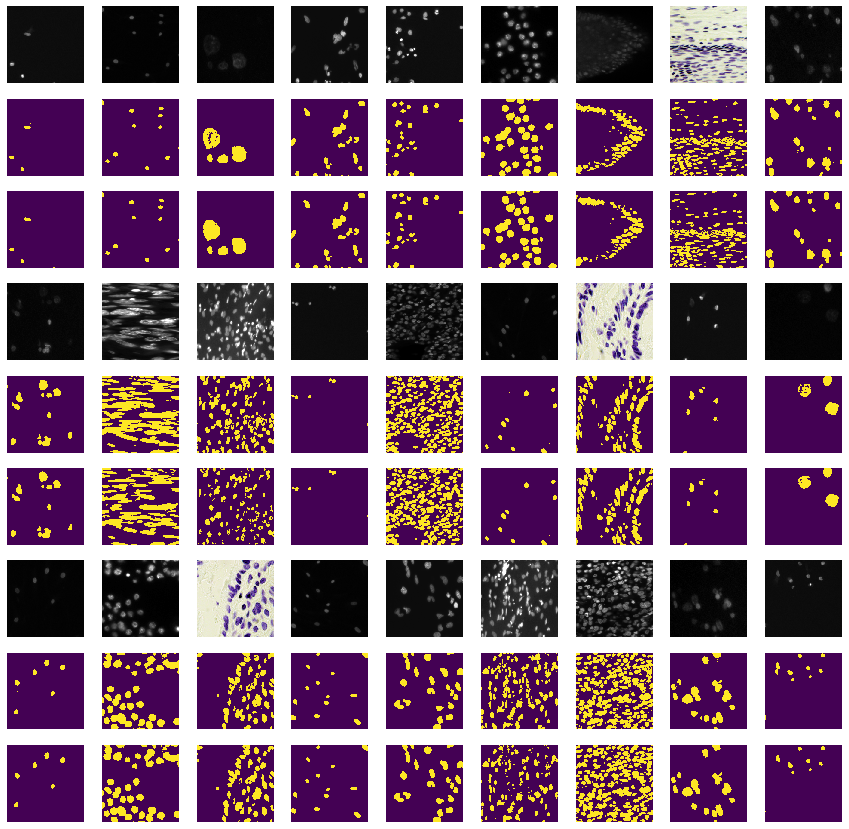

In [45]:
# predicted results of R2U-net
i= 0

fig, ax = plt.subplots(9, 9, figsize=(15,15))
for row in range(0,9,3 ):
  for col in range(9):
    #ostu thresholding predicted mask
    pred_im1 = y_hat_test1[i][:,:,0] 
    pred_im1 = pred_im1> threshold_otsu(pred_im1)
    pred_im2 = y_hat_test2[i][:,:,0] 
    pred_im2 = pred_im2> threshold_otsu(pred_im2)
    #show image
    ax[row, col].imshow(X_test[i])
    ax[row+1, col].imshow(pred_im1)
    ax[row+2, col].imshow(pred_im2)
    ax[row, col].axis('off')
    ax[row+1, col].axis('off')
    ax[row+2, col].axis('off')

    i += 1

# W-net 

In [0]:
from keras.applications.vgg16 import VGG16
from keras.initializers import RandomNormal
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, multiply, BatchNormalization, ReLU, Activation

def w_net(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    x1 = conv2d_block(input_img, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    x = MaxPooling2D((2, 2)) (x1)
    x = Dropout(dropout*0.5)(x)

    x2 = conv2d_block(x, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    x = MaxPooling2D((2, 2)) (x2)
    x = Dropout(dropout)(x)

    x3 = conv2d_block(x, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    x = MaxPooling2D((2, 2)) (x3)
    x = Dropout(dropout)(x)

    x4 = conv2d_block(x, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    x = MaxPooling2D(pool_size=(2, 2)) (x4)
    x = Dropout(dropout)(x)
    
    x5 = conv2d_block(x, n_filters=n_filters*32, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    x = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (x5)
    x = concatenate([x, x4])
    x= Dropout(dropout)(x)
    x = conv2d_block(x, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    x = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (x)
    x = concatenate([x, x3])
    x = Dropout(dropout)(x)
    x = conv2d_block(x, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    x = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (x)
    x = concatenate([x, x2])
    x = Dropout(dropout)(x)
    x = conv2d_block(x, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    x = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (x)
    x = concatenate([x, x1], axis=3)
    x = Dropout(dropout)(x)
    x = conv2d_block(x, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    x = Conv2D(filters=n_filters*1, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)

    # Decoder 2
    x_rb = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (x5)
    x_rb = concatenate([x4, x_rb])
    x_rb = Dropout(dropout)(x_rb)
    x_rb = conv2d_block(x_rb, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    x_rb = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(x_rb)
    x_rb = concatenate([x3, x_rb])
    x_rb = conv2d_block(x_rb, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    x_rb = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(x_rb)
    x_rb = concatenate([x2, x_rb])
    x_rb = conv2d_block(x_rb, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    x_rb = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (x_rb)
    x_rb = concatenate([x1, x_rb], axis=3)
    x_rb = Dropout(dropout)(x_rb)
    x_rb = conv2d_block(x_rb, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    x_rb = Conv2D(filters=n_filters*1, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x_rb)
    x_rb = BatchNormalization()(x_rb) if batchnorm else x_rb
    x_rb = Activation('relu')(x_rb)

    x_rb = Conv2D(1, kernel_size=(1, 1), padding='same', kernel_initializer="he_normal", activation='sigmoid')(x_rb)    # Sigmoid activation

    # Multiplication
    x = multiply([x, x_rb])
    outputs = Conv2D(1, (1, 1), padding='same', kernel_initializer="he_normal", activation='relu')(x)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

    # outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [47]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

model_3 = w_net(input_img,  batchnorm=True)

model_3.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 256, 256, 32) 128         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 256, 256, 32) 0           batch_normalization_73[0][0]     
____________________________________________________________________________________________

###Train model

In [48]:
callbacks_3 = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1),
    ModelCheckpoint('w_net', verbose=1, save_best_only=True, save_weights_only=True)]

results_3 = model_3.fit(X_train_edit, y_train_edit, batch_size= batch_size, epochs=epochs, callbacks=callbacks_3,
                    validation_data = (X_valid_edit, y_valid_edit))

Train on 536 samples, validate on 134 samples
Epoch 1/100
536/536 [==============================] - 29s 54ms/step - loss: 0.6498 - acc: 0.8830 - val_loss: 0.3341 - val_acc: 0.9057

Epoch 00001: val_loss improved from inf to 0.33408, saving model to w_net
Epoch 2/100
536/536 [==============================] - 15s 28ms/step - loss: 0.3132 - acc: 0.8877 - val_loss: 0.4625 - val_acc: 0.9128

Epoch 00002: val_loss did not improve from 0.33408
Epoch 3/100
536/536 [==============================] - 15s 28ms/step - loss: 0.2769 - acc: 0.9009 - val_loss: 0.4083 - val_acc: 0.9095

Epoch 00003: val_loss did not improve from 0.33408
Epoch 4/100
536/536 [==============================] - 15s 28ms/step - loss: 0.2282 - acc: 0.9103 - val_loss: 0.2196 - val_acc: 0.9185

Epoch 00004: val_loss improved from 0.33408 to 0.21958, saving model to w_net
Epoch 5/100
536/536 [==============================] - 15s 28ms/step - loss: 0.2093 - acc: 0.9215 - val_loss: 0.2221 - val_acc: 0.9103

Epoch 00005: val_los

###Model evaluation

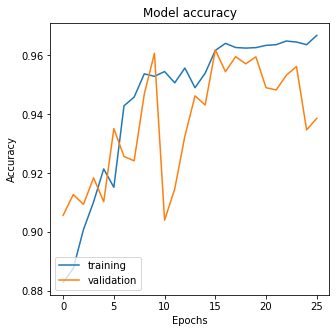

In [49]:
plt.figure(figsize=(5, 5))
plt.title("Model accuracy")
plt.plot(results_3.history["acc"], label="training")
plt.plot(results_3.history["val_acc"], label="validation")
# plt.plot( np.argmin(results_3.history["val_loss"]), np.min(results_3.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower left",)

In [50]:
y_hat_valid_3 = model_3.predict(X_valid_edit, verbose=1)
y_hat_valid_3.shape 

134/134 [==============================] - 4s 30ms/step


(134, 256, 256, 1)

In [51]:
# model evaluation
j_5,h_5,d_5= evaluation(y_valid_edit,y_hat_valid_3)

print("Jaccard similarity: {}".format(j_5))
print("Hausdorff distance:  {}".format(h_5))
print("Dice coefficient: {}".format(d_5))

Jaccard similarity: 0.7206169558762541
Hausdorff distance:  5.258555619013021
Dice coefficient: 0.8174548673362337


Jaccard similarity:  0.813
Hausdorff distance:  5.657
Dice coefficient:  0.897


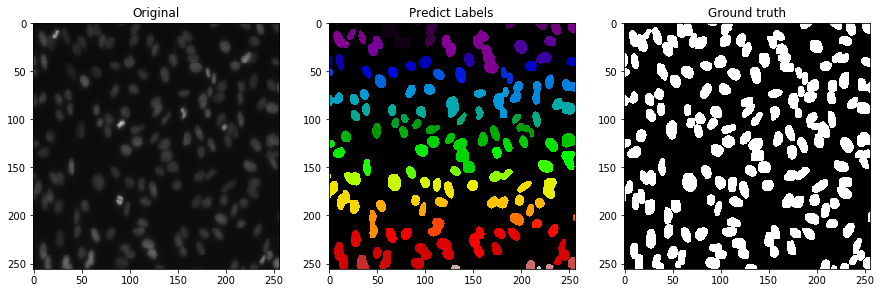

In [52]:
id = random.randint(0, len(y_hat_valid_3))
img_true= np.array(y_valid_edit[id][:,:,0]).astype(float)
pred_im = y_hat_valid_3[id][:,:,0] 
pred_im = pred_im> threshold_otsu(pred_im)
label_im, nb_labels = ndimage.label(pred_im)


fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(X_valid_edit[id])
ax[0].set_title('Original')
ax[1].imshow(label_im, cmap='nipy_spectral')
ax[1].set_title('Predict Labels')
ax[2].imshow(img_true, cmap = "gray")
ax[2].set_title('Ground truth')

jaccard = round(jaccard_score(img_true, pred_im, average= "micro"),3)
hausdorff = round(distance.directed_hausdorff(img_true, pred_im)[0],3)
dice_dis = round(1 - distance.dice(img_true.ravel(), pred_im.ravel()),3)

print("Jaccard similarity: ",jaccard)
print("Hausdorff distance: ", hausdorff)
print("Dice coefficient: ", dice_dis)

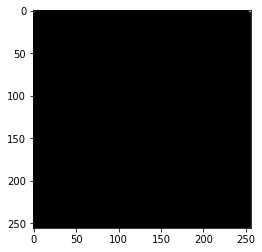

In [53]:
# predict black image
black_image = np.ones((256,256,3))
black_image = black_image.reshape((1,256,256,3))
black_image.shape
black_pred = model_3.predict(black_image)
black_pred= black_pred.reshape(256,256,1)
plt.imshow(black_pred[:,:,0], cmap="gray")

###Predict model

In [54]:
y_hat_test3 = model_3.predict(X_test, verbose=1)

65/65 [==============================] - 1s 8ms/step


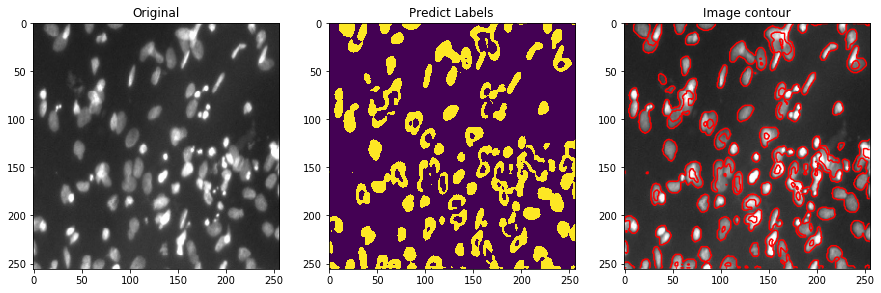

In [55]:
#test on a random image
id = random.randint(0, len(X_test))
pred_im = y_hat_test3[id][:,:,0] 
pred_im = pred_im> threshold_otsu(pred_im)
label_im, nb_labels = ndimage.label(pred_im)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(X_test[id])
ax[0].set_title('Original')
ax[1].imshow(pred_im)
ax[1].set_title('Predict Labels');
ax[2].imshow(X_test[id])
ax[2].contour(pred_im, colors='r', levels=[0.5])
ax[2].set_title('Image contour');

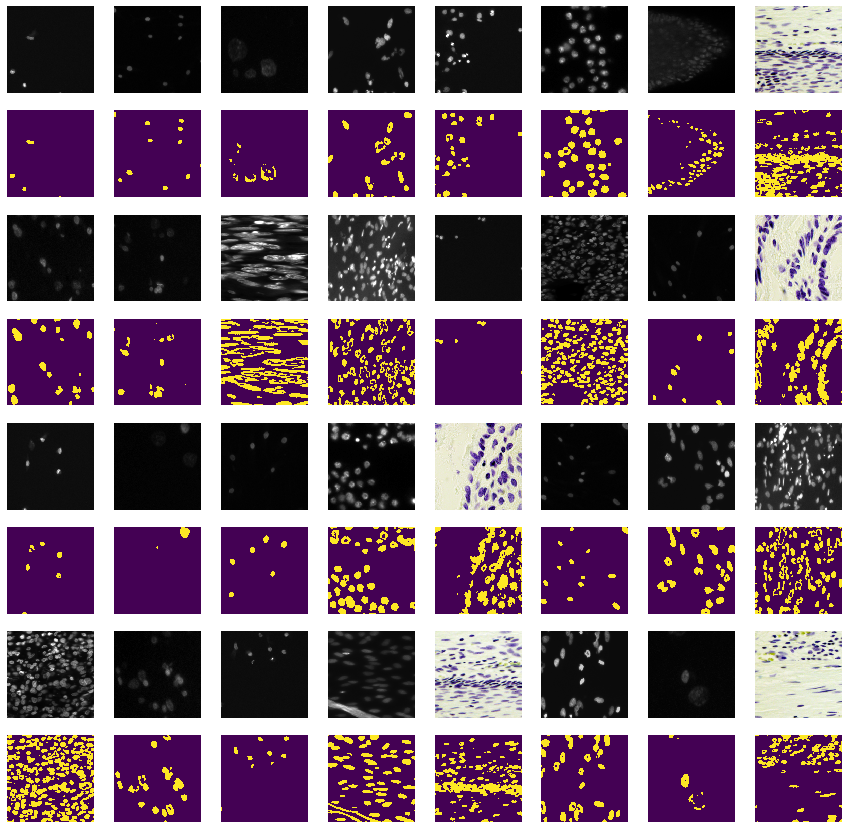

In [56]:
# predicted results of W-net
i= 0

fig, ax = plt.subplots(8, 8, figsize=(15,15))
for row in range(0,8,2 ):
  for col in range(8):
    #ostu thresholding predicted mask
    pred_im = y_hat_test3[i][:,:,0] 
    pred_im = pred_im> threshold_otsu(pred_im)
    #show image
    ax[row, col].imshow(X_test[i])
    ax[row+1, col].imshow(pred_im)
    ax[row, col].axis('off')
    ax[row+1, col].axis('off')

    i += 1
